In [1]:
# import zipfile
# with zipfile.ZipFile("/home/mira1/vlex_mira/acad/data_processed.zip", 'r') as zip_ref:
#     zip_ref.extractall("/home/mira1/vlex_mira/acad/")


In [1]:
import os
import sys; sys.path.insert(0, os.path.abspath("../../"))
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
from pathlib import Path
import time
import copy
import timm
from prettytable import PrettyTable

import logging
import torch
import torchvision

import pickle as pk

import torch.nn as nn
import torch.optim as optim

from torch.optim import lr_scheduler
from torch.utils.data import DataLoader, WeightedRandomSampler
from torcheval.metrics.functional import multiclass_confusion_matrix
from torchvision import datasets, models, transforms
from collections import Counter
from sklearn.metrics import balanced_accuracy_score, cohen_kappa_score
import kornia.losses as losses

from torch.utils.tensorboard import SummaryWriter
this_path = Path().resolve()

In [2]:
three_class_data = this_path.parent.parent/'data_processed/three_class/'
models_path = this_path.parent.parent/'models/three_class/'


In [3]:
experiment_no = 'exp13'
network_arch = 'swin_t'

experiment_path = models_path/network_arch/experiment_no
experiment_path.mkdir(parents=True, exist_ok=True)

cfg = {
    'data': {
        'exp_name' : network_arch + '/' + experiment_no,
        'data_dir' : three_class_data,
        'chkpt_path' : experiment_path,
        'best_model_path' : experiment_path/"best_model.pt",
        'tensorboard_path' : models_path/'tensorboard/',
        },
    'train': {
        'epochs' : 70,
        'batch_size' : 25,
        'lr' : 0.0001, # deafult:0.0001
        'momentum' : 0.9,
        'weight_decay' : 0.00005,
        'num_workers' : 2,
        'lr_step_size' : 5,
        'gamma' : 0.1,
        'milestones': [23, 40, 50],
        'sch_patience': 7,
        'sch_thresh': 0.001,
        'es_patience': 5,
        'es_delta': 0.02,
        'cuda': 'cuda:1',
        'loss': 'focal',
        'weight_criterion': False,
        'sampler': False,
        'optimizer': 'adam'
        },
    'val': {
        'batch_size' : 25,
        'num_workers' : 2,
        }
}

In [4]:
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomHorizontalFlip(),
        transforms.RandomVerticalFlip(),
        transforms.RandomRotation((0, 90), interpolation=transforms.InterpolationMode.BILINEAR),
        transforms.RandomAutocontrast(),
        transforms.GaussianBlur(3),
        transforms.ToTensor(),
        transforms.Normalize([0.6984, 0.5750, 0.5661], [0.1403, 0.1555, 0.1735])
    ]),
    'val': transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize([0.6984, 0.5750, 0.5661], [0.1403, 0.1555, 0.1735])
    ]),
}


datasets = {x: datasets.ImageFolder(os.path.join(cfg['data']['data_dir'], x), transform=data_transforms[x])
            for x in ['train', 'val']}
            
dataset_sizes = {x: len(datasets[x]) for x in ['train', 'val']}
print(f'Sizes: {dataset_sizes}')

class_names = datasets['train'].classes

device = torch.device(cfg['train']['cuda'] if torch.cuda.is_available() else "cpu") # "cpu"


Sizes: {'train': 5082, 'val': 1270}


In [6]:
# # Dataloaders

# # Get each sample class weight, for the train set
# train_classes = [label for _, label in datasets['train']] # from each sample, retrieve its label
# class_count = Counter(train_classes) # Count labels, returns dict with label:counts
# class_weights = torch.Tensor([len(train_classes)/c for c in pd.Series(class_count).sort_index().values]) # weights for each class total_samples/class_count

# # For sampler, we need a vector with each sample class weight
# sample_weights = [0] * len(datasets['train'])
# for idx, (image, label) in enumerate(datasets['train']):
#     class_weight = class_weights[label]
#     sample_weights[idx] = class_weight

# #save as binary file
# pk.dump(np.asarray(sample_weights), open(three_class_data/'train/3c_sample_weights.p', 'wb'))

# torch.save(class_weights, three_class_data/'train/3c_class_weights.pt')

dataloaders = {
        'val': DataLoader(
            datasets['val'], batch_size=cfg['val']['batch_size'],
            num_workers=cfg['val']['num_workers'], drop_last=False),
}

sample_weights = pk.load(open(three_class_data/'train/3c_sample_weights.p', 'rb'))

class_weights = torch.load(three_class_data/'train/3c_class_weights.pt')

if cfg['train']['sampler']:
        
    # Create sampler with sample_weights
    sampler = WeightedRandomSampler(weights=sample_weights,
                                    num_samples = dataset_sizes['train'], replacement=True)  

    # Assign sampler to train dataloader only
    dataloaders['train'] = DataLoader(
                datasets['train'], batch_size=cfg['train']['batch_size'],
                num_workers=cfg['val']['num_workers'], drop_last=False, sampler=sampler)
else:
    dataloaders['train'] = DataLoader(
                datasets['train'], batch_size=cfg['train']['batch_size'],
                num_workers=cfg['val']['num_workers'], drop_last=False, shuffle=True)

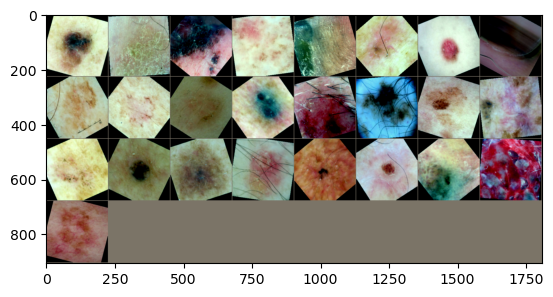

tensor([1, 1, 1, 2, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 2, 0, 0, 1, 1,
        2])


In [7]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=None)
print(classes)

### Train model

In [15]:
class EarlyStopper:
    def __init__(self, patience=1, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.min_validation_loss = np.inf

    def early_stop(self, validation_loss):
        if validation_loss < self.min_validation_loss:
            self.min_validation_loss = validation_loss
            self.counter = 0
        elif validation_loss > (self.min_validation_loss + self.min_delta):
            self.counter += 1
            if self.counter >= self.patience:
                return True
        return False
        
def train_model(model, criterion, optimizer, scheduler, writer, early_stopper, cfg, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    last_three_losses = []
    early_stopping_count = 0
    previous_mean_loss = 0


    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            labels_all = []
            preds_all = []
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)
                    if cfg['train']['loss'] == 'focal':
                        loss = loss.mean()

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
                labels_all.extend(labels.cpu().numpy())
                preds_all.extend(preds.cpu().numpy())
            if phase == 'train':
                scheduler.step()
            
            epoch_loss = running_loss / dataset_sizes[phase]

            # if phase == 'val':
            #     scheduler.step(epoch_loss)
            #     # print(f"Last LR: {optimizer.param_groups[0]['lr']} --- ")

            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            # print(f'Preds all: {np.unique(preds_all, return_counts=True)}')

            epoch_kappa = cohen_kappa_score(labels_all, preds_all)
            epoch_bal_acc = balanced_accuracy_score(labels_all, preds_all)
            
            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')
            print(f'        Kappa: {epoch_kappa:.4f} Acc_bal {epoch_bal_acc:.4f}')
            writer.add_scalars('acc',{f'{phase}': epoch_acc}, epoch+1)
            writer.add_scalars('bal_acc',{f'{phase}': epoch_bal_acc}, epoch+1)
            writer.add_scalars('loss',{f'{phase}': epoch_loss}, epoch+1)
            writer.add_scalars('kappa',{f'{phase}': epoch_kappa}, epoch+1)

            # save last and best checkpoint
            torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'configuration': cfg,
                'loss': epoch_loss}, cfg['data']['chkpt_path']/f'last_checkpoint_{epoch}.pt')


            # deep copy the model
            if phase == 'val' and epoch_kappa > best_acc:
                best_acc = epoch_kappa
                best_model_wts = copy.deepcopy(model.state_dict())

                best_metric = best_acc
                
                torch.save({
                    'model_state_dict': model.state_dict(),
                    'metrics': best_metric,
                    'configuration': cfg
                    }, cfg['data']['best_model_path'])

        if phase == 'val':
            if early_stopper.early_stop(epoch_loss):
                print(f'Training stopped at epoch {epoch}')             
                break
        # if epoch == (num_epochs-1):
        #     if phase == 'val':
        #         print(f'Conf matrix: {multiclass_confusion_matrix(preds_all, labels_all, 3)}')
        # print()

    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best val Kappa: {best_acc:4f}')

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

def test_model(model, loader):
    correct = 0
    total = 0
    # since we're not training, we don't need to calculate the gradients for our outputs
    with torch.no_grad():
        labels_all = []
        preds_all = []
        for data in loader:
            images, labels = data
            images = images.to(device)
            labels = labels.to(device)

            # calculate outputs by running images through the network
            outputs = model(images)

            # the class with the highest energy is what we choose as prediction
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += torch.sum(predicted == labels.data)
            labels_all.extend(labels.cpu().numpy())
            preds_all.extend(predicted.cpu().numpy())

        epoch_kappa = cohen_kappa_score(labels_all, preds_all)
        epoch_bal_acc = balanced_accuracy_score(labels_all, preds_all)
        epoch_cm = multiclass_confusion_matrix(torch.Tensor(preds_all).type(dtype=torch.long), 
                                                torch.Tensor(labels_all).type(dtype=torch.long), 3)
        print(torch.Tensor(preds_all).type())
        print(type(torch.Tensor(preds_all)), type(torch.Tensor(labels_all)))
        print(f'Conf matrix: {epoch_cm}')
        print(f'Bal accuracy: {epoch_bal_acc:.4f}, kappa: {epoch_kappa:4f}')
    
    return labels_all, preds_all

def count_parameters(model):
    table = PrettyTable(["Modules", "Parameters"])
    total_params = 0
    for name, parameter in model.named_parameters():
        if not parameter.requires_grad: continue
        params = parameter.numel()
        table.add_row([name, params])
        total_params+=params
    print(table)
    print(f"Total Trainable Params: {total_params}")
    return total_params

### Swin_t

In [9]:
model_ft = models.swin_t(weights=models.Swin_T_Weights.IMAGENET1K_V1)
num_ftrs = model_ft.head.in_features
# model_ft.head = nn.Linear(num_ftrs, 3)
model_ft.head = nn.Sequential(
                        nn.Linear(num_ftrs, 512),
                        nn.ReLU(),
                        nn.Linear(512, 256),
                        nn.ReLU(),
                        nn.Linear(256, 3)
                        )

model_ft = model_ft.to(device)

if cfg['train']['loss'] == 'focal':
    criterion = losses.FocalLoss(0.6)
else:
    if cfg['train']['weight_criterion']:
        class_weights = class_weights.to(device)  
        criterion = nn.CrossEntropyLoss(class_weights)
    else:
        criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
if cfg['train']['optimizer'] == 'adam':
    optimizer_ft = optim.Adam(params=model_ft.parameters(), lr=cfg['train']['lr'], weight_decay=cfg['train']['weight_decay'])
else:
    optimizer_ft = optim.SGD(model_ft.parameters(), lr=cfg['train']['lr'], momentum=cfg['train']['momentum'])

if cfg['train']['milestones'] is not None:
    exp_lr_scheduler = lr_scheduler.MultiStepLR(optimizer=optimizer_ft, milestones=cfg['train']['milestones'], gamma=cfg['train']['gamma'])
else:
    exp_lr_scheduler = lr_scheduler.ReduceLROnPlateau(optimizer=optimizer_ft, patience=cfg['train']['sch_patience'], 
                                                mode='min', threshold=cfg['train']['sch_thresh'], verbose=True)   

# Decay LR by a factor of gamma every lr_step_size epochs
# exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=cfg['train']['lr_step_size'], 
#                                         gamma=cfg['train']['gamma'])

# count_parameters(model_ft)

In [11]:
logdir = cfg['data']['tensorboard_path']/network_arch/experiment_no
print(logdir)
writer = SummaryWriter(logdir)
early_stopper = EarlyStopper(patience=cfg['train']['es_patience'], min_delta=cfg['train']['es_delta'])
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler, writer, early_stopper, cfg=cfg,
                       num_epochs=cfg['train']['epochs'])
writer.flush()

/home/mira1/vlex_mira/acad/models/three_class/tensorboard/swin_t/exp13
Epoch 0/69
----------
train Loss: 0.1358 Acc: 0.7904
        Kappa: 0.6039 Acc_bal 0.5665
val Loss: 0.1029 Acc: 0.8409
        Kappa: 0.7062 Acc_bal 0.6240
Epoch 1/69
----------
train Loss: 0.0957 Acc: 0.8489
        Kappa: 0.7183 Acc_bal 0.6565
val Loss: 0.0888 Acc: 0.8520
        Kappa: 0.7275 Acc_bal 0.7016
Epoch 2/69
----------
train Loss: 0.0874 Acc: 0.8501
        Kappa: 0.7229 Acc_bal 0.6803
val Loss: 0.0753 Acc: 0.8780
        Kappa: 0.7704 Acc_bal 0.7078
Epoch 3/69
----------
train Loss: 0.0698 Acc: 0.8815
        Kappa: 0.7824 Acc_bal 0.7359
val Loss: 0.0858 Acc: 0.8567
        Kappa: 0.7459 Acc_bal 0.7830
Epoch 4/69
----------
train Loss: 0.0634 Acc: 0.8849
        Kappa: 0.7895 Acc_bal 0.7518
val Loss: 0.0618 Acc: 0.8961
        Kappa: 0.8102 Acc_bal 0.7935
Epoch 5/69
----------
train Loss: 0.0583 Acc: 0.9008
        Kappa: 0.8188 Acc_bal 0.7906
val Loss: 0.0603 Acc: 0.9102
        Kappa: 0.8403 Acc_bal 

In [20]:
y, y_pred = test_model(model_ft, dataloaders['val'])

torch.FloatTensor
<class 'torch.Tensor'> <class 'torch.Tensor'>
Conf matrix: tensor([[472,  18,   8],
        [ 19, 651,   8],
        [  9,   6,  79]])
Bal accuracy: 0.9161, kappa: 0.903758


### Regnet

In [8]:
model_ft = models.regnet_y_800mf(weights=models.RegNet_Y_800MF_Weights.DEFAULT)
num_ftrs = model_ft.fc.in_features

# Here the size of each output sample is set to 3.
# Alternatively, it can be generalized to nn.Linear(num_ftrs, len(class_names)).
model_ft.fc = nn.Linear(num_ftrs, 3)

model_ft = model_ft.to(device)

if cfg['train']['weight_criterion']:
    class_weights = class_weights.to(device)  
    criterion = nn.CrossEntropyLoss(class_weights)
else:
    criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
if cfg['train']['optimizer'] == 'adam':
    optimizer_ft = optim.Adam(params=model_ft.parameters(), lr=cfg['train']['lr'], weight_decay=cfg['train']['weight_decay'])
else:
    optimizer_ft = optim.SGD(model_ft.parameters(), lr=cfg['train']['lr'], momentum=cfg['train']['momentum'])

# Decay LR by a factor of gamma every lr_step_size epochs
# exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=cfg['train']['lr_step_size'], 
#                                         gamma=cfg['train']['gamma'])

exp_lr_scheduler = lr_scheduler.ReduceLROnPlateau(optimizer=optimizer_ft, patience=cfg['train']['sch_patience'], 
                                                mode='min', threshold=cfg['train']['sch_thresh'], verbose=True)                                

# count_parameters(model_ft)

In [42]:
logdir = cfg['data']['tensorboard_path']/network_arch/experiment_no
writer = SummaryWriter(logdir)
early_stopper = EarlyStopper(patience=cfg['train']['es_patience'], min_delta=cfg['train']['es_delta'])
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler, writer, early_stopper,
                       num_epochs=cfg['train']['epochs'])
writer.flush()

Epoch 0/49
----------
train Loss: 0.7469 Acc: 0.6942
        Kappa: 0.4214 Acc_bal 0.4951
val Loss: 0.6703 Acc: 0.7283
        Kappa: 0.5053 Acc_bal 0.5362
Epoch 1/49
----------
train Loss: 0.5878 Acc: 0.7769
        Kappa: 0.5793 Acc_bal 0.5576
val Loss: 0.5767 Acc: 0.7795
        Kappa: 0.5919 Acc_bal 0.5701
Epoch 2/49
----------
train Loss: 0.5392 Acc: 0.7973
        Kappa: 0.6182 Acc_bal 0.5779
val Loss: 0.5333 Acc: 0.7961
        Kappa: 0.6193 Acc_bal 0.5795
Epoch 3/49
----------
train Loss: 0.5181 Acc: 0.8056
        Kappa: 0.6345 Acc_bal 0.5818
val Loss: 0.5158 Acc: 0.8071
        Kappa: 0.6413 Acc_bal 0.5887
Epoch 4/49
----------
train Loss: 0.4950 Acc: 0.8154
        Kappa: 0.6530 Acc_bal 0.5958
val Loss: 0.4862 Acc: 0.8157
        Kappa: 0.6539 Acc_bal 0.5949
Epoch 5/49
----------
train Loss: 0.4745 Acc: 0.8245
        Kappa: 0.6707 Acc_bal 0.6091
val Loss: 0.4815 Acc: 0.8165
        Kappa: 0.6610 Acc_bal 0.5968
Epoch 6/49
----------
train Loss: 0.4618 Acc: 0.8296
        Kap

### Densenet121

In [8]:
model_ft = models.densenet121(weights=models.DenseNet121_Weights.DEFAULT)
num_ftrs = model_ft.classifier.in_features

# Here the size of each output sample is set to 2.
# Alternatively, it can be generalized to nn.Linear(num_ftrs, len(class_names)).
model_ft.classifier = nn.Linear(num_ftrs, 2)

model_ft = model_ft.to(device)
criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.Adam(params=model_ft.parameters(), lr=cfg['train']['lr'], weight_decay=cfg['train']['weight_decay'])
# optimizer_ft = optim.SGD(model_ft.parameters(), lr=cfg['train']['lr'], momentum=cfg['train']['momentum'])

# Decay LR by a factor of gamma every lr_step_size epochs
# exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=cfg['train']['lr_step_size'], 
#                                         gamma=cfg['train']['gamma'])

exp_lr_scheduler = lr_scheduler.ReduceLROnPlateau(optimizer=optimizer_ft, patience=cfg['train']['sch_patience'], 
                                                mode='min', threshold=cfg['train']['sch_thresh'], verbose=True)                                

count_parameters(model_ft)

+------------------------------------------------+------------+
|                    Modules                     | Parameters |
+------------------------------------------------+------------+
|             features.conv0.weight              |    9408    |
|             features.norm0.weight              |     64     |
|              features.norm0.bias               |     64     |
| features.denseblock1.denselayer1.norm1.weight  |     64     |
|  features.denseblock1.denselayer1.norm1.bias   |     64     |
| features.denseblock1.denselayer1.conv1.weight  |    8192    |
| features.denseblock1.denselayer1.norm2.weight  |    128     |
|  features.denseblock1.denselayer1.norm2.bias   |    128     |
| features.denseblock1.denselayer1.conv2.weight  |   36864    |
| features.denseblock1.denselayer2.norm1.weight  |     96     |
|  features.denseblock1.denselayer2.norm1.bias   |     96     |
| features.denseblock1.denselayer2.conv1.weight  |   12288    |
| features.denseblock1.denselayer2.norm2

6955906

In [9]:
# count = 0
# for i,param in enumerate(model_ft.parameters()):
#         if i < 200:
#                 param.requires_grad = False
#                 count+=1
# print(count)
# count_parameters(model_ft)

200
+------------------------------------------------+------------+
|                    Modules                     | Parameters |
+------------------------------------------------+------------+
| features.denseblock3.denselayer14.conv2.weight |   36864    |
| features.denseblock3.denselayer15.norm1.weight |    704     |
|  features.denseblock3.denselayer15.norm1.bias  |    704     |
| features.denseblock3.denselayer15.conv1.weight |   90112    |
| features.denseblock3.denselayer15.norm2.weight |    128     |
|  features.denseblock3.denselayer15.norm2.bias  |    128     |
| features.denseblock3.denselayer15.conv2.weight |   36864    |
| features.denseblock3.denselayer16.norm1.weight |    736     |
|  features.denseblock3.denselayer16.norm1.bias  |    736     |
| features.denseblock3.denselayer16.conv1.weight |   94208    |
| features.denseblock3.denselayer16.norm2.weight |    128     |
|  features.denseblock3.denselayer16.norm2.bias  |    128     |
| features.denseblock3.denselayer16.

4198978

In [ ]:
# # freezing some initial layers
# ct = 0
# for child in model_ft.children():
#     ct += 1
#     if ct <= 6:
#         for param in child.parameters():
#             param.requires_grad = False

# count_parameters(model_ft)

In [9]:
logdir = cfg['data']['tensorboard_path']/network_arch/experiment_no
writer = SummaryWriter(logdir)
early_stopper = EarlyStopper(patience=10, min_delta=0.01)
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler, writer, early_stopper,
                       num_epochs=cfg['train']['epochs'])
writer.flush()

Epoch 0/59
----------
train Loss: 0.4679 Acc: 0.7828
Last LR: 1e-05 --- 
val Loss: 0.4050 Acc: 0.8132

Epoch 1/59
----------
train Loss: 0.3916 Acc: 0.8217
Last LR: 1e-05 --- 
val Loss: 0.3713 Acc: 0.8325

Epoch 2/59
----------
train Loss: 0.3656 Acc: 0.8377
Last LR: 1e-05 --- 
val Loss: 0.3599 Acc: 0.8311

Epoch 3/59
----------
train Loss: 0.3421 Acc: 0.8478
Last LR: 1e-05 --- 
val Loss: 0.3479 Acc: 0.8422

Epoch 4/59
----------
train Loss: 0.3244 Acc: 0.8578
Last LR: 1e-05 --- 
val Loss: 0.3430 Acc: 0.8443

Epoch 5/59
----------
train Loss: 0.3118 Acc: 0.8630
Last LR: 1e-05 --- 
val Loss: 0.3442 Acc: 0.8398

Epoch 6/59
----------
train Loss: 0.3039 Acc: 0.8687
Last LR: 1e-05 --- 
val Loss: 0.3298 Acc: 0.8498

Epoch 7/59
----------
train Loss: 0.2863 Acc: 0.8745
Last LR: 1e-05 --- 
val Loss: 0.3282 Acc: 0.8462

Epoch 8/59
----------
train Loss: 0.2771 Acc: 0.8788
Last LR: 1e-05 --- 
val Loss: 0.3181 Acc: 0.8496

Epoch 9/59
----------
train Loss: 0.2692 Acc: 0.8863
Last LR: 1e-05 --- 


### Resnet-18

In [8]:
model_ft = models.resnet18(weights=models.ResNet18_Weights.DEFAULT)
num_ftrs = model_ft.fc.in_features

# Here the size of each output sample is set to 2.
# Alternatively, it can be generalized to nn.Linear(num_ftrs, len(class_names)).
model_ft.classifier = nn.Linear(num_ftrs, 2)

model_ft = model_ft.to(device)
criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
# optimizer_ft = optim.Adam(params=model_ft.parameters(), lr=cfg['train']['lr'], weight_decay=cfg['train']['weight_decay'])
optimizer_ft = optim.SGD(model_ft.parameters(), lr=cfg['train']['lr'], momentum=cfg['train']['momentum'])

# Decay LR by a factor of gamma every lr_step_size epochs
# exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=cfg['train']['lr_step_size'], 
#                                         gamma=cfg['train']['gamma'])

exp_lr_scheduler = lr_scheduler.ReduceLROnPlateau(optimizer=optimizer_ft, mode='min', threshold=0.001, verbose=True)                                

count_parameters(model_ft)

+------------------------------+------------+
|           Modules            | Parameters |
+------------------------------+------------+
|         conv1.weight         |    9408    |
|          bn1.weight          |     64     |
|           bn1.bias           |     64     |
|    layer1.0.conv1.weight     |   36864    |
|     layer1.0.bn1.weight      |     64     |
|      layer1.0.bn1.bias       |     64     |
|    layer1.0.conv2.weight     |   36864    |
|     layer1.0.bn2.weight      |     64     |
|      layer1.0.bn2.bias       |     64     |
|    layer1.1.conv1.weight     |   36864    |
|     layer1.1.bn1.weight      |     64     |
|      layer1.1.bn1.bias       |     64     |
|    layer1.1.conv2.weight     |   36864    |
|     layer1.1.bn2.weight      |     64     |
|      layer1.1.bn2.bias       |     64     |
|    layer2.0.conv1.weight     |   73728    |
|     layer2.0.bn1.weight      |    128     |
|      layer2.0.bn1.bias       |    128     |
|    layer2.0.conv2.weight     |  

11690538

In [9]:
# freezing some initial layers
ct = 0
for child in model_ft.children():
    ct += 1
    if ct <= 6:
        for param in child.parameters():
            param.requires_grad = False

count_parameters(model_ft)

+------------------------------+------------+
|           Modules            | Parameters |
+------------------------------+------------+
|    layer3.0.conv1.weight     |   294912   |
|     layer3.0.bn1.weight      |    256     |
|      layer3.0.bn1.bias       |    256     |
|    layer3.0.conv2.weight     |   589824   |
|     layer3.0.bn2.weight      |    256     |
|      layer3.0.bn2.bias       |    256     |
| layer3.0.downsample.0.weight |   32768    |
| layer3.0.downsample.1.weight |    256     |
|  layer3.0.downsample.1.bias  |    256     |
|    layer3.1.conv1.weight     |   589824   |
|     layer3.1.bn1.weight      |    256     |
|      layer3.1.bn1.bias       |    256     |
|    layer3.1.conv2.weight     |   589824   |
|     layer3.1.bn2.weight      |    256     |
|      layer3.1.bn2.bias       |    256     |
|    layer4.0.conv1.weight     |  1179648   |
|     layer4.0.bn1.weight      |    512     |
|      layer4.0.bn1.bias       |    512     |
|    layer4.0.conv2.weight     |  

11007466

In [10]:
logdir = cfg['data']['tensorboard_path']/network_arch/experiment_no
writer = SummaryWriter(logdir)
early_stopper = EarlyStopper(patience=20, min_delta=0.01)
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler, writer, early_stopper,
                       num_epochs=cfg['train']['epochs'])
writer.flush()

Epoch 0/59
----------
train Loss: 0.9174 Acc: 0.7368
Last LR: 0.0005 --- 
val Loss: 0.4123 Acc: 0.8119

Epoch 1/59
----------
train Loss: 0.3699 Acc: 0.8315
Last LR: 0.0005 --- 
val Loss: 0.3768 Acc: 0.8282

Epoch 2/59
----------
train Loss: 0.3154 Acc: 0.8596
Last LR: 0.0005 --- 
val Loss: 0.3656 Acc: 0.8343

Epoch 3/59
----------
train Loss: 0.2861 Acc: 0.8759
Last LR: 0.0005 --- 
val Loss: 0.3563 Acc: 0.8422

Epoch 4/59
----------
train Loss: 0.2503 Acc: 0.8960
Last LR: 0.0005 --- 
val Loss: 0.3549 Acc: 0.8443

Epoch 5/59
----------
train Loss: 0.2206 Acc: 0.9139
Last LR: 0.0005 --- 
val Loss: 0.3493 Acc: 0.8485

Epoch 6/59
----------
train Loss: 0.1912 Acc: 0.9247
Last LR: 0.0005 --- 
val Loss: 0.3515 Acc: 0.8488

Epoch 7/59
----------
train Loss: 0.1629 Acc: 0.9389
Last LR: 0.0005 --- 
val Loss: 0.3558 Acc: 0.8519

Epoch 8/59
----------
train Loss: 0.1362 Acc: 0.9504
Last LR: 0.0005 --- 
val Loss: 0.3663 Acc: 0.8485

Epoch 9/59
----------
train Loss: 0.1172 Acc: 0.9585
Last LR: 0.

### Resnet50

In [8]:
model_ft = models.resnet50(weights=models.ResNet50_Weights.DEFAULT)
num_ftrs = model_ft.fc.in_features
num_ftrs

2048

In [9]:
model_ft = models.resnet50(weights=models.ResNet50_Weights.DEFAULT)
num_ftrs = model_ft.fc.in_features
# Here the size of each output sample is set to 2.
# Alternatively, it can be generalized to nn.Linear(num_ftrs, len(class_names)).
# model_ft.classifier = nn.Sequential(
#                         nn.Linear(num_ftrs, 512),
#                         nn.ReLU(),
#                         nn.Linear(512, 256),
#                         nn.ReLU(),
#                         nn.Linear(256, 3)
#                         )

model_ft.classifier = nn.Linear(num_ftrs, 3)

model_ft = model_ft.to(device)

if cfg['train']['weight_criterion']:
    class_weights = class_weights.to(device)  
    criterion = nn.CrossEntropyLoss(class_weights)
else:
    criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
if cfg['train']['optimizer'] == 'adam':
    optimizer_ft = optim.Adam(params=model_ft.parameters(), lr=cfg['train']['lr'], weight_decay=cfg['train']['weight_decay'])
else:
    optimizer_ft = optim.SGD(model_ft.parameters(), lr=cfg['train']['lr'], momentum=cfg['train']['momentum'])

# Decay LR by a factor of gamma every lr_step_size epochs
# exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=cfg['train']['lr_step_size'], 
#                                         gamma=cfg['train']['gamma'])

exp_lr_scheduler = lr_scheduler.ReduceLROnPlateau(optimizer=optimizer_ft, patience=cfg['train']['sch_patience'], 
                                                mode='min', threshold=cfg['train']['sch_thresh'], verbose=True)                                

# count_parameters(model_ft)

In [ ]:
# print model's layers to have an idea of the layers

# [module for module in model_ft.modules() if not isinstance(module, nn.Sequential)]
# dict(model_ft.named_modules())
for child in model_ft.children():
    print(child)

In [9]:
# freezing some initial layers
ct = 0
for child in model_ft.children():
    ct += 1
    if ct <= 6:
        for param in child.parameters():
            param.requires_grad = False

count_parameters(model_ft)

+------------------------------+------------+
|           Modules            | Parameters |
+------------------------------+------------+
|    layer3.0.conv1.weight     |   131072   |
|     layer3.0.bn1.weight      |    256     |
|      layer3.0.bn1.bias       |    256     |
|    layer3.0.conv2.weight     |   589824   |
|     layer3.0.bn2.weight      |    256     |
|      layer3.0.bn2.bias       |    256     |
|    layer3.0.conv3.weight     |   262144   |
|     layer3.0.bn3.weight      |    1024    |
|      layer3.0.bn3.bias       |    1024    |
| layer3.0.downsample.0.weight |   524288   |
| layer3.0.downsample.1.weight |    1024    |
|  layer3.0.downsample.1.bias  |    1024    |
|    layer3.1.conv1.weight     |   262144   |
|     layer3.1.bn1.weight      |    256     |
|      layer3.1.bn1.bias       |    256     |
|    layer3.1.conv2.weight     |   589824   |
|     layer3.1.bn2.weight      |    256     |
|      layer3.1.bn2.bias       |    256     |
|    layer3.1.conv3.weight     |  

24116202

In [10]:
logdir = cfg['data']['tensorboard_path']/network_arch/experiment_no
writer = SummaryWriter(logdir)
early_stopper = EarlyStopper(patience=cfg['train']['es_patience'], min_delta=cfg['train']['es_delta'])
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler, writer, early_stopper,
                       num_epochs=cfg['train']['epochs'])
writer.flush()

Epoch 0/49
----------


/home/mira1/miniconda3/envs/acad/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1987: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


train Loss: 1.2806 Acc: 0.7255
        Kappa: 0.5306 Acc_bal 0.5504
val Loss: 0.4715 Acc: 0.8260
        Kappa: 0.6697 Acc_bal 0.6249

Epoch 1/49
----------
train Loss: 0.4253 Acc: 0.8392
        Kappa: 0.7038 Acc_bal 0.6868
val Loss: 0.4742 Acc: 0.8150
        Kappa: 0.6533 Acc_bal 0.6887

Epoch 2/49
----------
train Loss: 0.3399 Acc: 0.8760
        Kappa: 0.7729 Acc_bal 0.7488
val Loss: 0.3615 Acc: 0.8646
        Kappa: 0.7469 Acc_bal 0.7194

Epoch 3/49
----------
train Loss: 0.2822 Acc: 0.8933
        Kappa: 0.8059 Acc_bal 0.7927
val Loss: 0.3386 Acc: 0.8756
        Kappa: 0.7680 Acc_bal 0.7066

Epoch 4/49
----------
train Loss: 0.2474 Acc: 0.9087
        Kappa: 0.8339 Acc_bal 0.8186


/home/mira1/miniconda3/envs/acad/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1987: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


val Loss: 0.3140 Acc: 0.8780
        Kappa: 0.7729 Acc_bal 0.7475

Epoch 5/49
----------
train Loss: 0.2224 Acc: 0.9179
        Kappa: 0.8510 Acc_bal 0.8369
val Loss: 0.3087 Acc: 0.8850
        Kappa: 0.7917 Acc_bal 0.7950

Epoch 6/49
----------
train Loss: 0.1962 Acc: 0.9305
        Kappa: 0.8743 Acc_bal 0.8677
val Loss: 0.2838 Acc: 0.8913
        Kappa: 0.8005 Acc_bal 0.7567

Epoch 7/49
----------
train Loss: 0.1835 Acc: 0.9370
        Kappa: 0.8861 Acc_bal 0.8830
val Loss: 0.2946 Acc: 0.8882
        Kappa: 0.7948 Acc_bal 0.7993

Epoch 8/49
----------
train Loss: 0.1512 Acc: 0.9465
        Kappa: 0.9034 Acc_bal 0.9027


/home/mira1/miniconda3/envs/acad/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1987: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


val Loss: 0.3020 Acc: 0.9079
        Kappa: 0.8332 Acc_bal 0.8184

Epoch 9/49
----------
train Loss: 0.1482 Acc: 0.9475
        Kappa: 0.9049 Acc_bal 0.8985
val Loss: 0.2787 Acc: 0.9008
        Kappa: 0.8212 Acc_bal 0.8383

Epoch 10/49
----------
train Loss: 0.1186 Acc: 0.9601
        Kappa: 0.9279 Acc_bal 0.9222


/home/mira1/miniconda3/envs/acad/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1987: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


val Loss: 0.2342 Acc: 0.9220
        Kappa: 0.8589 Acc_bal 0.8474

Epoch 11/49
----------
train Loss: 0.1113 Acc: 0.9589
        Kappa: 0.9258 Acc_bal 0.9231
val Loss: 0.2107 Acc: 0.9228
        Kappa: 0.8594 Acc_bal 0.8335

Epoch 12/49
----------
train Loss: 0.1006 Acc: 0.9646
        Kappa: 0.9362 Acc_bal 0.9387
val Loss: 0.2297 Acc: 0.9236
        Kappa: 0.8624 Acc_bal 0.8762

Epoch 13/49
----------
train Loss: 0.0941 Acc: 0.9691
        Kappa: 0.9443 Acc_bal 0.9433
val Loss: 0.2362 Acc: 0.9252
        Kappa: 0.8660 Acc_bal 0.8790

Epoch 14/49
----------
train Loss: 0.0802 Acc: 0.9697
        Kappa: 0.9453 Acc_bal 0.9390
val Loss: 0.2988 Acc: 0.9118
        Kappa: 0.8374 Acc_bal 0.8180

Epoch 15/49
----------
train Loss: 0.0777 Acc: 0.9703
        Kappa: 0.9465 Acc_bal 0.9454
val Loss: 0.2898 Acc: 0.9071
        Kappa: 0.8350 Acc_bal 0.8875

Epoch 16/49
----------
train Loss: 0.0727 Acc: 0.9752
        Kappa: 0.9554 Acc_bal 0.9564
val Loss: 0.2780 Acc: 0.9150
        Kappa: 0.8470 A

AttributeError: 'list' object has no attribute 'size'

### Inception Resnet V2

In [8]:
model_ft = timm.create_model('inception_resnet_v2', pretrained=True, num_classes=2)
model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.Adam(params=model_ft.parameters(), lr=cfg['train']['lr'], weight_decay=cfg['train']['weight_decay'])
# optimizer_ft = optim.SGD(model_ft.parameters(), lr=cfg['train']['lr'], momentum=cfg['train']['momentum'])

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=cfg['train']['lr_step_size'], 
                                        gamma=cfg['train']['gamma'])


In [9]:
logdir = cfg['data']['tensorboard_path']/'inception_resnet_v2/exp3'
writer = SummaryWriter(logdir)
early_stopper = EarlyStopper(patience=3, min_delta=10)
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler, writer, early_stopper,
                       num_epochs=cfg['train']['epochs'])
writer.flush()

Epoch 0/29
----------
train Loss: 0.4138 Acc: 0.8099
val Loss: 0.3909 Acc: 0.8280

Epoch 1/29
----------
train Loss: 0.3586 Acc: 0.8382
val Loss: 0.3640 Acc: 0.8375

Epoch 2/29
----------
train Loss: 0.3382 Acc: 0.8546
val Loss: 0.3527 Acc: 0.8419

Epoch 3/29
----------
train Loss: 0.3220 Acc: 0.8564
val Loss: 0.4213 Acc: 0.8159

Epoch 4/29
----------
train Loss: 0.3087 Acc: 0.8627
val Loss: 0.3348 Acc: 0.8459

Epoch 5/29
----------
train Loss: 0.2545 Acc: 0.8917
val Loss: 0.3107 Acc: 0.8606

Epoch 6/29
----------
train Loss: 0.2351 Acc: 0.9029
val Loss: 0.3067 Acc: 0.8654

Epoch 7/29
----------
train Loss: 0.2226 Acc: 0.9094
val Loss: 0.3036 Acc: 0.8680

Epoch 8/29
----------
train Loss: 0.2092 Acc: 0.9119
val Loss: 0.3041 Acc: 0.8714

Epoch 9/29
----------
train Loss: 0.1989 Acc: 0.9162
val Loss: 0.3052 Acc: 0.8688

Epoch 10/29
----------
train Loss: 0.1850 Acc: 0.9227
val Loss: 0.3046 Acc: 0.8746

Epoch 11/29
----------
train Loss: 0.1797 Acc: 0.9267
val Loss: 0.3067 Acc: 0.8730

Ep